# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

### 1.1 Loading the dataset (parquet format) 

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import sys

sys.path.append('../../src/utils')


# Utilities
from housing_prices_column_definition import Column

datasetPath = '../../datasets/processed/housing_prices/hyderabad_house_price_original.parquet'
processedPath = '../../datasets/processed/housing_prices/hyderabad_house_price_processed.parquet'
dataset = pd.read_parquet(datasetPath)

### 1.2  Handling Inconsistent Values in Amenity Columns

**Problem:**

The EDA revealed that multiple binary columns representing amenities (e.g., Gymnasium, SwimmingPool, MaintenanceStaff) contain the value 9, which is inconsistent with the expected binary format of 0 or 1.

**Justification:**

The value 9 is a common placeholder for missing or unknown information. Leaving it in would cause the model to treat it as a third, distinct category, which is incorrect. 

**Action:**

We'll treat these values ​​as missing data. The most robust strategy is to eliminate them, since we're not sure what the value 9 represents, and the samples involved are few.


In [2]:
df = dataset.copy()  
df = df.select_dtypes(include=["int64", "float64"]).drop(columns=[Column.PRICE.name, Column.AREA.name, Column.NO_OF_BEDROOMS.name])

columns = df.columns.tolist()
affected_examples = (df[columns] == 9).any(axis=1)

# Remove invalid samples
dataset = dataset[~affected_examples]

display(Markdown('**Verification:**')) 
print(f"Samples with invalid value before remove them: {affected_examples.sum()}")
print(f"Samples with invalid value after remove them  {(dataset[columns] == 9).any(axis=1).sum()}")

dataset.to_parquet(datasetPath)

**Verification:**

Samples with invalid value before remove them: 84
Samples with invalid value after remove them  0


## 1.3 Transformation of Skewed Numerical Features

**Problem:**
The numerical features Price and Area have highly right-skewed distributions, as observed in their descriptive statistics (the mean is significantly greater than the median). This can negatively affect the performance of models that are sensitive to the scale and distribution of the data, such as linear models.

**Justification:**

A logarithmic transformation (np.log1p) compresses the range of the higher values, reducing the impact of outliers and making the distribution more symmetrical (similar to a normal distribution). This helps to stabilize the variance and meet the assumptions of many Machine Learning algorithms, which generally leads to better performance and a more robust model.

**Action:**

- Apply the np.log1p transformation to the Price and Area columns to normalize their distribution.
- It is not advisable to apply a logarithmic transformation to the No. of Bedrooms column. Unlike Price and Area, this variable is not continuous, but discrete, and has a very small and limited range of values (e.g., 1, 2, 3, 4, 5 bedrooms). Logarithmic transformation will not provide any benefits and will complicate the interpretation of the model.

**Verification:**

Before (left) and after (right) applying logarithm


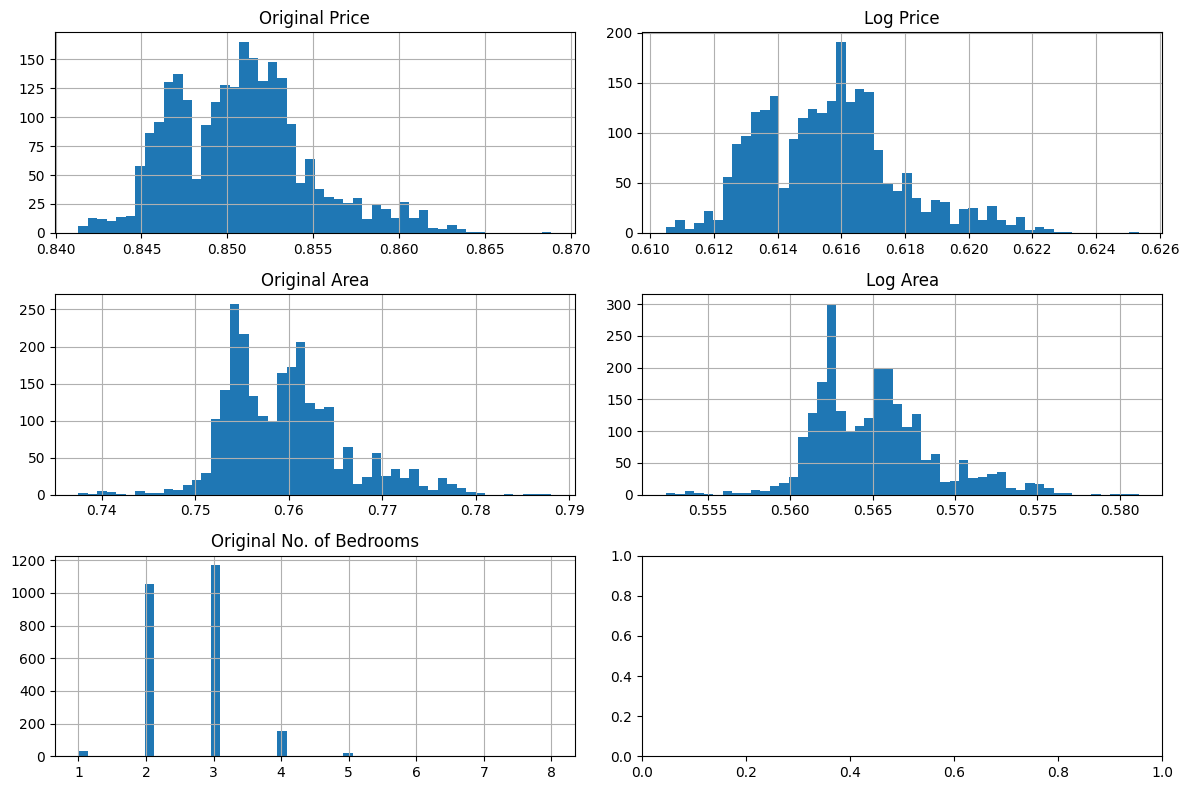

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

dataset[Column.PRICE.name].hist(ax=axes[0,0], bins=50).set_title('Original Price')
dataset[Column.AREA.name].hist(ax=axes[1,0], bins=50).set_title('Original Area')
dataset[Column.NO_OF_BEDROOMS.name].hist(ax=axes[2,0], bins=50).set_title('Original No. of Bedrooms')

dataset[Column.PRICE.name] = np.log1p(dataset[Column.PRICE.name])
dataset[Column.AREA.name] = np.log1p(dataset[Column.AREA.name])

dataset[Column.PRICE.name].hist(ax=axes[0,1], bins=50).set_title('Log Price')
dataset[Column.AREA.name].hist(ax=axes[1,1], bins=50).set_title('Log Area')

display(Markdown('**Verification:**'))
print("Before (left) and after (right) applying logarithm") 
plt.tight_layout()
plt.show()

dataset.to_parquet(datasetPath)

## 1.3 Grouping Infrequent Locations and Hot encoding

**Problem:**

Machine learning algorithms require numeric inputs. The Location column is categorical and has a very high number of unique values (high cardinality), which makes standard One-Hot Encoding impractical.

Justification:

Creating a separate column for each of the 239 locations would lead to the "curse of dimensionality," making the model unnecessarily complex and potentially prone to overfitting. A more effective strategy is to group infrequent locations into a single "Other" category. This approach reduces the number of dimensions while retaining the most statistically significant locations. We can then apply One-Hot Encoding to this simplified set of categories.

Action:

- Identify all locations that appear fewer times than a specified threshold (e.g., 10 times).
- Replace these infrequent location names with the string "Other".
- Apply pd.get_dummies to the modified Location column to create the final numeric features.
- Amenities columns do not need to be converted to one-hot encoding because they are already in a binary or Boolean format that is understandable by machine learning algorithms.
-  The No. of Bedrooms variable is ordinal numerical, not nominal categorical, which means its values have an inherent and significant order of magnitude. In practice, applying one-hot encoding to this variable is a mistake.

In [4]:
location_counts = dataset[Column.LOCATION.name].value_counts()
threshold = 10

unique_locations_before = dataset[Column.LOCATION.name].nunique()
infrequent_locations = location_counts[location_counts < threshold].index
locations_modified = dataset[Column.LOCATION.name].replace(infrequent_locations, 'Other')
uniqueLocationAfter = locations_modified.nunique()

location_dummies = pd.get_dummies(locations_modified, prefix=Column.LOCATION.name, drop_first=True)

dataset_with_dummies = pd.concat([dataset, location_dummies], axis=1)
dataset_with_dummies = dataset.drop(columns=[Column.LOCATION.name])

display(Markdown('**Verification:**'))
print(f"Number of unique locations before clustering {unique_locations_before}") 
print(f"Number of unique locations after clustering: {uniqueLocationAfter}") 

dataset_with_dummies.to_parquet(processedPath)

**Verification:**

Number of unique locations before clustering 239
Number of unique locations after clustering: 55
